In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage

# Image analysis

Let's start with a simple image loaded last time we had class:
    

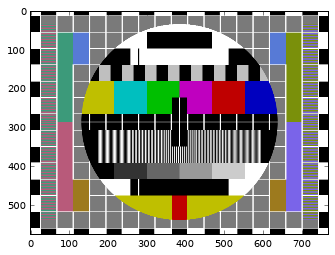

In [2]:
from PIL import Image  # this is the pillow package
import requests  # from webscraping

try:  # python2
    from StringIO import StringIO
except:  # python3
    from io import BytesIO

image_loc = 'https://upload.wikimedia.org/wikipedia/commons/c/c4/PM5544_with_non-PAL_signals.png'
response = requests.get(image_loc)  # choose one of the files to show as an example
try:
    img = Image.open(BytesIO(response.content))
except:
    img = Image.open(StringIO(response.content))

index = np.asarray(img)
plt.imshow(index)

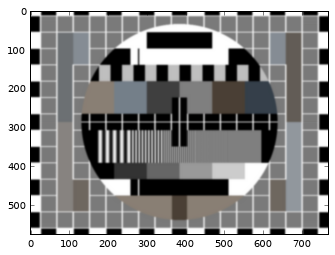

In [3]:
findex = ndimage.gaussian_filter(index, 2.0)    # filters in all 'three' dimensions, including channel...
plt.imshow(findex)                              # ...probably not what we want.

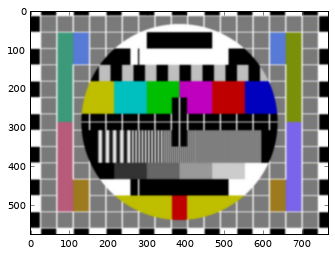

In [4]:
sigma = 2.0    # Standard deviation of the gaussian kernel. Bigger sigma == more smoothing.

findex = np.zeros_like(index)
for channel in range(3):
    findex[:, :, channel] = ndimage.gaussian_filter(index[:, :, channel], sigma=sigma)

plt.imshow(findex)

---
###  *Exercise*

> Modify the sigma parameter, and see what happens to the image.

---

Now, let's see if we can find gradients in this image. To make it easier, let's make a psudo-grayscale image by summing the RGB channels.

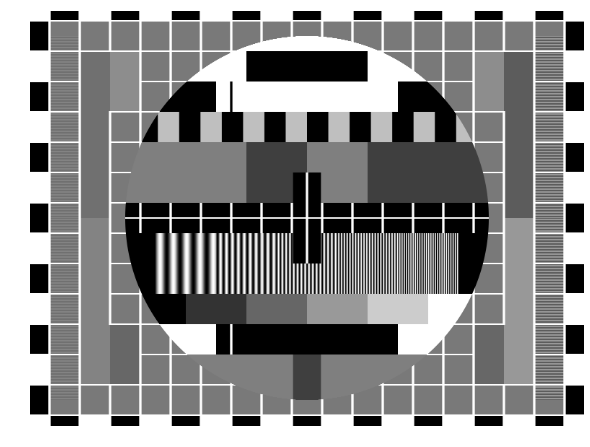

In [5]:
gsindex = index.sum(axis=-1)

fig = plt.figure(figsize=(7.68, 5.76), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
plt.imshow(gsindex, cmap='gray')

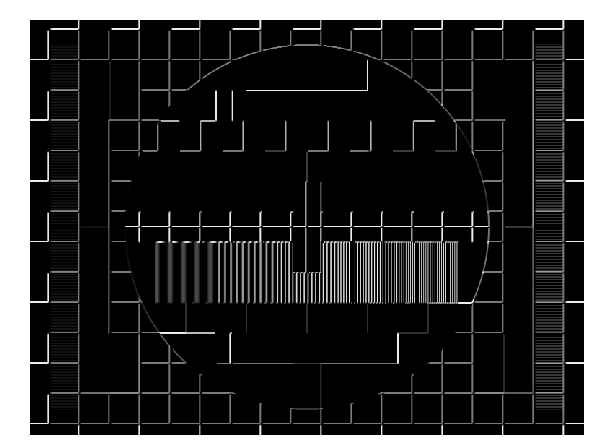

In [6]:
# FINDING GRADIENTS

from scipy.ndimage import sobel, generic_gradient_magnitude
d_gsindex = ndimage.generic_gradient_magnitude(gsindex, sobel)

# Note screen resolution is about 100dpi, so lets make sure the image is big enough to see all the points.
fig = plt.figure(figsize=(7.68, 5.76))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.matshow(d_gsindex, cmap='gray')

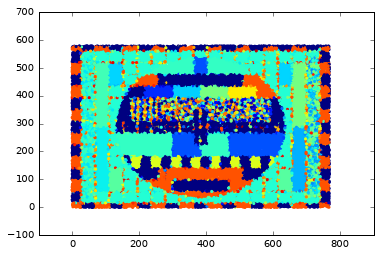

In [7]:
# INTERPOLATION/MAPPING

x = 768*np.random.rand(50000)
y = 578*np.random.rand(50000)
xy = np.vstack((y, x))

z = ndimage.map_coordinates(gsindex, xy)
plt.scatter(x, y, 10, z, edgecolor='none')

((755, 891), (576, 768))


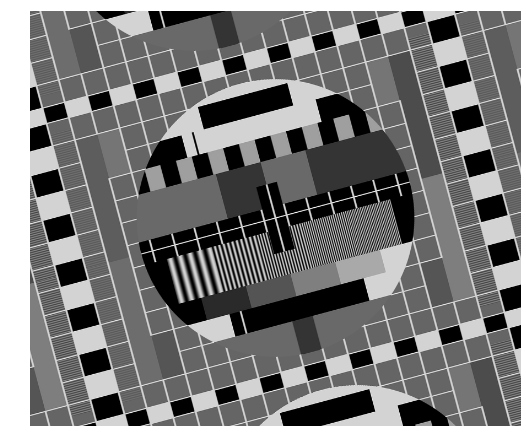

In [11]:
# ROTATING

rgsindex = ndimage.rotate(gsindex, 15, mode='wrap')
fig = plt.figure(figsize=(7.68, 5.76), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
plt.imshow(rgsindex, cmap='gray')

# Note, the image size increased to accomodate the rotation.
print(rgsindex.shape, gsindex.shape)

---
###  *Exercise*

> Try some other rotations. Does the increase in image size make sense based on trigenometry? What happens with a 90deg
rotation?

> Look at the documentation, and try different modes. What's the difference between 'constant' and 'wrap'

> Try rotating back and fourth 15 degrees at least 10 times, using various modes (and be be sure to set 'reshape=False' to prevent the image from growing over the iterations).

---

### An example of edge detection

Let's use some of these tools to generate a sample image – a rotated square with softened edges, and some noise added.

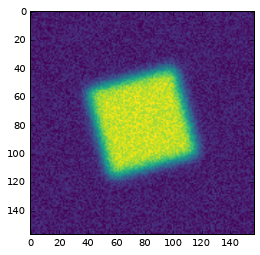

In [18]:
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndimage.rotate(im, 15, mode='constant')
im = ndimage.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

plt.imshow(im, cmap='viridis')

Now, try to detect the edges of this feature using the scikit image canny edge detection algorithm:

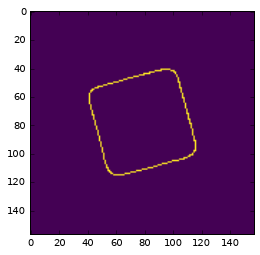

In [37]:
from skimage import feature

edges = feature.canny(im, sigma=3)    # sigma=1 is the default
plt.imshow(edges, cmap='viridis')

---
###  *Exercise*

> Try different values of sigma to see if you can isolate the square as the only feature detected.

---

Now let's find the convex hull of the edges that we detected (hopefully only the single square now):

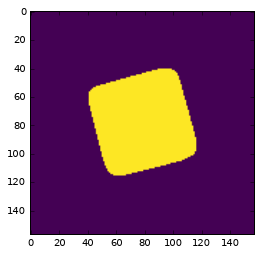

In [38]:
from skimage.morphology import convex_hull_image

chull = convex_hull_image(edges)
plt.imshow(chull, cmap='viridis')

This would work even for an 'open' object, 

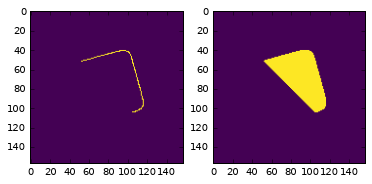

In [45]:
diag_mask = np.triu(np.ones(im.shape))
edges = edges.astype('float') * diag_mask

chull = convex_hull_image(edges)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(edges, cmap='viridis')
axs[1].imshow(chull, cmap='viridis')

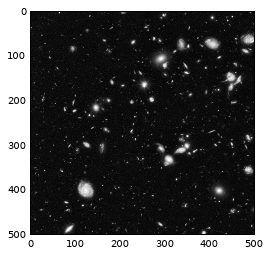

In [49]:
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

plt.imshow(image_gray, cmap='gray')

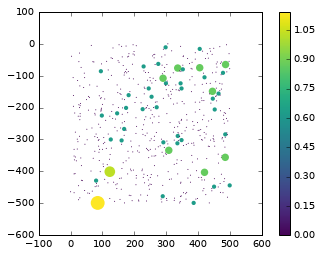

In [77]:
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# the data are x, y, radii for all the blobs. Lets make a quick plot.

y = blobs_log[:, 0]
x = blobs_log[:, 1]
r = blobs_log[:, 2]

plt.scatter(x, -y, r**2, np.log10(r), cmap='viridis', edgecolor='none')
plt.gca().set_aspect(1.0)
plt.colorbar()


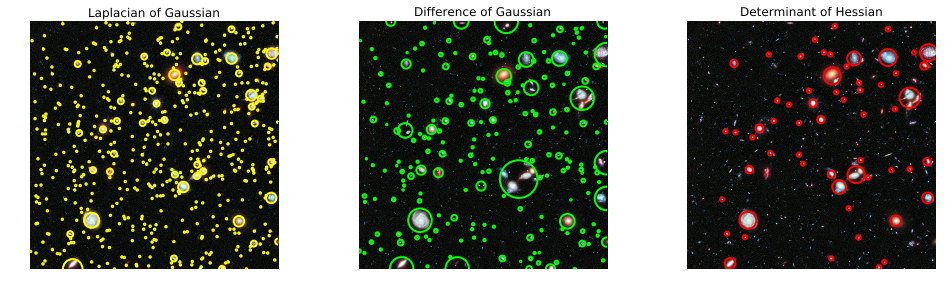

In [58]:
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
plt.tight_layout()

axes = axes.ravel()
for blobs, color, title in sequence:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title(title)
    ax.imshow(image, interpolation='nearest')
    ax.set_axis_off()
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

plt.show()